### Table comparing barcoded Prom and Gridion
Generates comparison tables for unblocked and sequenced metrics for the clinical mappy-rs table.


Sequencing summary files were created with dorado basecall server v7.3.9

Separated with `rftools` which requires the unblocked read ids file, https://github.com/LooseLab/rftools

```bash
rftools split-ss -p <PREFIX> `20220317_1702_3A_PAK09329_4cae256c` sequencing_summary_PAK09329_e742ec3b.txt
```

where <PREFIX> is one of a combination of sequencing device and run number, i.e grid1, prom2 etc.

Split sequencing summarys were trimmed to only contain relevant information using `qsvlite` - see https://github.com/jqnatividad/qsv?tab=readme-ov-file#option-3-install-with-rust
Using the select command:
```bash
fd -e.txt ed -x qsvlite select -d "\t" -o {.}_lite.tsv read_id,sample_id,sequence_length_template,barcode_arrangement {}
```

And then compressed with `xz` (in parallel with `fd`, just repalce {} with the filename to be compressed if not using `fd`

```bash
fd -tf lite -x xz -T 24 -e -z {}
```

### Alignment
Alignment was originally performed by dorado basecall server v7.3.9. Inidividual bam files were merged sorted and indexed with samtools v1.20, bash script used included in this repo `merge_bam_files.sh`
Both PASS and FAIL data is included.
The data was called with HAC.

### For coverage on and off target
To generate files for on and off target coverage we used `mosdepth 0.3.6`.
First the reads were mapped to Hg38.p14 with all alt and unplaced contigs removed, leaving only the main chromosome assemblies. 
Inverse complements regions (for off target based coverage) to the target bed files used were generated with `bedtools v2.31.1`
This requires the bedfile to be sorted, this can be done with `bedtools sort`.

```bash
fd -e .sorted.bed -x sh -c 'bedtools complement -i -g /data/refs/hg38_simple.genome > {.}_inverse_complement.bed'
```

A script to run mosdepth for the inverse and on target bed files is provided in this directory, `mosdepth_bam_files.sh`

## Warning
This notebook is memory hungry (>10Gb RAM required). If this is an issue, contact us and we will work out a way to calculate these metrics without loading everything into a dataframe.

In [1]:
import gc
import re
import sys
from itertools import chain, repeat, zip_longest
from pathlib import Path

import numpy as np
import pandas as pd

/home/mbxrm5/miniforge3/envs/jupyter-lab/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mbxrm5/miniforge3/envs/jupyter-lab/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def n50(lengths: pd.Series) -> float:
    """
    Returns the N50 of a series of read lengths
    """
    lengths = lengths.sort_values(ascending=False).values
    cumulative_sum = lengths.cumsum()
    total_length = cumulative_sum[-1]
    n50_length = lengths[(cumulative_sum >= total_length / 2).argmax()]
    return n50_length

# read in the sequencing summaries

In [3]:
barcodes = [f"barcode{n}" for n in ("17", "18", "19", "20", "21", "22")]
barcodes.append("unclassified")

In [4]:
PAT = re.compile(r"(sequenced|unblocked)")
dfs = []
for summary in Path("sequencing_summaries").glob("*d_seq_sum.*_lite.tsv"):
    print(summary)
    read_type = PAT.findall(summary.name)[0]
    df = pd.read_csv(summary, sep="\t")
    df["read_type"] = read_type
    dfs.append(df)

sequencing_summaries/ds1332_combined_seq_sum.sequenced_lite.tsv
sequencing_summaries/ds1332_combined_seq_sum.unblocked_lite.tsv


In [5]:
prom_df = pd.concat(dfs)
prom_summary = prom_df.groupby(["read_type", "barcode_arrangement"])[
    "sequence_length_template"
].agg(["count", np.median, np.sum, n50])
# Select correct barcodes
prom_summary = prom_summary.loc[:, barcodes, :]

/tmp/ipykernel_3995722/937191551.py:4: FutureWarning: The provided callable <function median at 0x7f0ae4107be0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  ].agg(["count", np.median, np.sum, n50])
/tmp/ipykernel_3995722/937191551.py:4: FutureWarning: The provided callable <function sum at 0x7f0afc34f520> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ].agg(["count", np.median, np.sum, n50])


In [6]:
testing = prom_summary
testing = testing.reset_index().rename(
    columns={
        "barcode_arrangement": "Barcode",
        "median": "Median",
        "sum": "Yield",
        "n50": "N50",
    }
)
testing["read_type"] = testing["read_type"].map(
    {"sequenced": "Seq.", "unblocked": "Unb."}
)

t = testing.pivot(
    index=["Barcode"],
    columns="read_type",
    values=[
        "Yield",
        "Median",
        "N50",
    ],
)
# Assign the panel information
# t[["Sample", "Panel", "Gene number"]] = pd.DataFrame.from_records(
#     t.index.get_level_values(0).map(prom_samples), index=t.index
# )

#### Get the coverage from mosdepth


In [7]:
def read_coverages_of_regions(search_path: str) -> pd.DataFrame:
    """Read the mosdepth coverage region bed files filtering to the given barcodes.
    Create a concatenated datafrom of all files, with barcode, coverage and on and off target and return it.
    """
    prom = ("17", "18", "19", "20", "21", "22")
    pat = re.compile(r"(barcode|unclassified)_*(\d{2})*.*")
    coverages = []
    for barcode in prom:
        files = list(Path(search_path).glob(f"*{barcode}*.bed.gz"))
        # print(files)
        for region_file in files:
            region_type = (
                "Off target"
                if "off_target" in str(region_file) or "inverse" in str(region_file)
                else "On target"
            )
            print(f"\t{region_file}\t{region_type}")
            barcode = "".join(pat.findall(str(region_file))[0])
            # Unclassified and off target bed files do not provide names for records so we shift index for Coverage column down one
            df = pd.read_csv(
                region_file, sep="\t", header=None, usecols=[3], names=["Coverage"]
            )
            df["barcode"] = barcode
            df["region_type"] = region_type
            #             P. or G. to match the barcode/device assignement in main dataframe
            # df["Device"] = f"{device[0].upper()}."
            coverages.append(df)
    return pd.concat(coverages)

In [8]:
coverage_df = read_coverages_of_regions("mosdepth_region_summaries/")
a = (
    coverage_df.groupby(["barcode", "region_type"])["Coverage"]
    .median()
    .reset_index()
    .pivot(index=["barcode"], columns="region_type", values="Coverage")
)
a.index.names = ["Barcode"]
# Assign coverages
t[["Off Target Median", "Target Median"]] = a
# Reorder the rows to this order
# t = t.reindex(
#     [
#         ("barcode01", "G."),
#         ("barcode02", "G."),
#         ("barcode03", "G."),
#         ("unclassified_grid", "G."),
#         ("barcode05", "P."),
#         ("barcode06", "P."),
#         ("barcode07", "P."),
#         ("unclassified_prom", "P."),
#     ]
# )
# Assign absolute fold difference bewteen on and off target coverage
t["Fold Enrichment"] = t["Target Median"] / t["Off Target Median"]
# Not used for the unclassified fields
t.loc[["unclassified"], "Fold Enrichment"] = "*"

	mosdepth_region_summaries/barcode17_panel_adaptive_nogenenames_20122021_hg38.sorted.merged.inverse.regions.bed.gz	Off target
	mosdepth_region_summaries/barcode17_panel_adaptive_nogenenames_20122021_hg38.sorted.merged.regions.bed.gz	On target
	mosdepth_region_summaries/barcode18_panel_adaptive_nogenenames_20122021_hg38.sorted.merged.inverse.regions.bed.gz	Off target
	mosdepth_region_summaries/barcode18_panel_adaptive_nogenenames_20122021_hg38.sorted.merged.regions.bed.gz	On target
	mosdepth_region_summaries/barcode19_panel_adaptive_nogenenames_20122021_hg38.sorted.merged.inverse.regions.bed.gz	Off target
	mosdepth_region_summaries/barcode19_panel_adaptive_nogenenames_20122021_hg38.sorted.merged.regions.bed.gz	On target
	mosdepth_region_summaries/barcode19_panel_adaptive_nogenenames_20122021_hg38.sorted.merged.inverse.regions.bed.gz	Off target
	mosdepth_region_summaries/barcode21_panel_adaptive_nogenenames_20122021_hg38_VGL_CHD7.sorted.merged.inverse.regions.bed.gz	Off target
	mosdepth_

/tmp/ipykernel_3995722/2927104175.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '*' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  t.loc[["unclassified"], "Fold Enrichment"] = "*"


In [9]:
total_df = t.agg(
    {
        ("Median", "Seq."): "mean",
        ("Median", "Unb."): "mean",
        ("Yield", "Seq."): "sum",
        ("Yield", "Unb."): "sum",
        ("N50", "Seq."): "mean",
        ("N50", "Unb."): "mean",
        ("Off Target Median", ""): "median",
        ("Target Median", ""): "median",
    }
).reset_index()
total_df["Barcode"] = "Total"
t = pd.concat((t, total_df.pivot(index="Barcode", columns="index", values=0)))
#  Reorder one more time
# t = t.reindex(
#     [
#         "barcode17",
#         "barcode18",
#         "barcode19",
#         "barcode20",
#         "barcode21",
#         "barcode22",
#         "unclassified",
#         "Total"
#     ]
# )

In [10]:
def format_bases(num: int, factor: int = 1000, suffix: str = "B") -> str:
    """Return a human readable string of a large number using SI unit prefixes

    :pararm num: A number to convert to decimal form
    :param factor: The SI factor, use 1000 for SI units and 1024 for binary multiples
    :param suffix: The suffix to place after the SI prefix, for example use B for SI units and iB for binary multiples
    :return: The input number formatted to two decimal places with the SI unit and suffix

    :Example:

    >>> format_bases(1_000)
    '1.00 kB'
    >>> format_bases(1_000_000)
    '1.00 MB'
    >>> format_bases(1_630_000)
    '1.63 MB'
    >>> format_bases(1_000_000_000)
    '1.00 GB'
    """
    if isinstance(num, float) or isinstance(num, int):
        for unit in ["", "k", "M", "G", "T", "P", "E", "Z"]:
            if abs(num) < factor:
                return f"{num:3.2f}{unit}{suffix}"
            num /= factor
        return f"{num:3.2f}"
    else:
        return num


def format_fold(x: int) -> str:
    """
    Format the fold change
    """
    if not isinstance(x, float):
        return x
    # Check if the value is an integer
    if isinstance(x, (int, float)) and x == int(x):
        return f"{int(x)}x"
    # Otherwise, format to one decimal place
    elif isinstance(x, float):
        return f"{x:.1f}x"
    return x

In [11]:
t = t.fillna("")
t.columns.names = [None, "End Reason"]
idx = pd.IndexSlice
subset = idx[
    :,
    [(metric, end_reason) for end_reason in ("Seq.", "Unb.") for metric in ["Yield"]],
]
idx2 = pd.IndexSlice
subset2 = idx2[:, ("Fold Enrichment", "")]
idx3 = pd.IndexSlice
subset3 = idx3[
    :,
    [
        ("Yield", "Seq."),
        ("Yield", "Unb."),
        ("Median", "Seq."),
        ("Median", "Unb."),
        ("N50", "Seq."),
        ("N50", "Unb."),
        ("Off Target Median", ""),
        ("Target Median", ""),
        ("Fold Enrichment", ""),
    ],
]
s = (
    (
        # Not proud of this loc, in here to exlude the mean columns, because I couldn't manage the slice to get the to hide
        t.loc[:, ~t.columns.isin([("Mean", "Seq."), ("Mean", "Unb.")])]
        .style.hide(axis=0, level=1, names=True)
        #          Format all numerical values to no decimal points
        .format(precision=0, subset=subset3, thousands=",")
        .format(format_bases, subset=subset)
        # .format(
        #     "\\textbf{{{}}}",
        #     subset=idx[
        #         [("Total", "G."), ("Total", "P.")],
        #         :,
        #     ],
        #     precision=0,
        #     thousands=","
        # )
        .relabel_index(
            t.loc[:, ~t.columns.isin([("Mean", "Seq."), ("Mean", "Unb.")])]
            .columns.get_level_values(0)
            .map(lambda x: "Yield\n(Gb)" if str(x) == "Yield" else x),
            axis=1,
            level=0,
        )
        .format_index(escape="latex", axis=0)
        #         Make columns label bold
        .format_index("\\textbf{{{}}}", escape="latex", axis=1, level=[0, 1])
        .to_latex(
            position_float="centering",
            hrules=True,
            column_format="".join(repeat("X ", len(t.columns) - 2 + 1)),
            environment="table",
        )
    )
    #     Manual replaces of the latex string
    .replace(r"\begin{tabular}", r"\begin{tabularx}{\textwidth}")
    .replace("\centering", "\centering\n\scriptsize")
    .replace("unclassified\_grid", "unclassified")
    .replace("unclassified\_prom", "unclassified")
    .replace("Total & 2.99", "\midrule\nTotal & 2.99")
    .replace("Total", r"\textbf{Total}")
)

In [12]:
print(s)

\begin{table}
\centering
\scriptsize
\begin{tabularx}{\textwidth}{X X X X X X X X}
\toprule
 & \multicolumn{2}{r}{\textbf{Yield}} & \multicolumn{2}{r}{\textbf{Median}} & \multicolumn{2}{r}{\textbf{N50}} & \textbf{Off Target Median} & \textbf{Target Median} & \textbf{Fold Enrichment} \\
End Reason & \textbf{Seq.} & \textbf{Unb.} & \textbf{Seq.} & \textbf{Unb.} & \textbf{Seq.} & \textbf{Unb.} & \textbf{} & \textbf{} & \textbf{} \\
\midrule
barcode17 & 1.27GB & 4.14GB & 336 & 735 & 8,599 & 765 & 1 & 10 & 10 \\
barcode18 & 1.27GB & 4.16GB & 382 & 732 & 14,402 & 759 & 1 & 11 & 11 \\
barcode19 & 1.06GB & 3.28GB & 335 & 731 & 12,606 & 759 & 1 & 9 & 9 \\
barcode20 & 1.03GB & 3.80GB & 335 & 724 & 10,872 & 749 & 1 & 10 & 10 \\
barcode21 & 3.40GB & 11.50GB & 354 & 739 & 406 & 779 & 4 & 9 & 2 \\
barcode22 & 1.14GB & 3.56GB & 332 & 721 & 9,398 & 748 & 1 & 9 & 9 \\
unclassified & 6.18GB & 3.08GB & 391 & 740 & 12,575 & 812 & 2 & 6 & * \\
\textbf{Total} & 15.36GB & 33.52GB & 352 & 732 & 9,837 & 767 & 

In [14]:
format_bases(
    int(
        prom_df[prom_df["barcode_arrangement"] != "unclassified"][
            "sequence_length_template"
        ].values.sum()
    )
    - int(
        prom_df[prom_df["barcode_arrangement"] == "unclassified"][
            "sequence_length_template"
        ].values.sum()
    )
)

'30.36GB'

In [19]:
prom_df[
    (prom_df["barcode_arrangement"] == "barcode21")
    & (prom_df["sequence_length_template"] >= 800)
].groupby(["read_type", "barcode_arrangement"])["sequence_length_template"].agg(
    ["count", np.median, np.sum, n50]
)

/tmp/ipykernel_3995722/1642452188.py:3: FutureWarning: The provided callable <function median at 0x7f0ae4107be0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  ].agg(["count", np.median, np.sum, n50])
/tmp/ipykernel_3995722/1642452188.py:3: FutureWarning: The provided callable <function sum at 0x7f0afc34f520> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ].agg(["count", np.median, np.sum, n50])


,,count,median,sum,n50
read_type,barcode_arrangement,,,,
sequenced,barcode21,355596,1223.0,794165822,3052
unblocked,barcode21,5502666,886.0,5137635033,898


<Axes: ylabel='Frequency'>

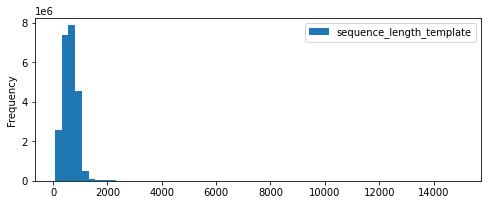

In [28]:
prom_df[
    (prom_df["barcode_arrangement"] == "barcode21")
    & (prom_df["sequence_length_template"] <= 15000)
].plot.hist(bins=60, figsize=(8, 3))

In [33]:
barcodes

['barcode17',
 'barcode18',
 'barcode19',
 'barcode20',
 'barcode21',
 'barcode22',
 'unclassified']

In [70]:
import seaborn as sns
from matplotlib import ticker as mticker

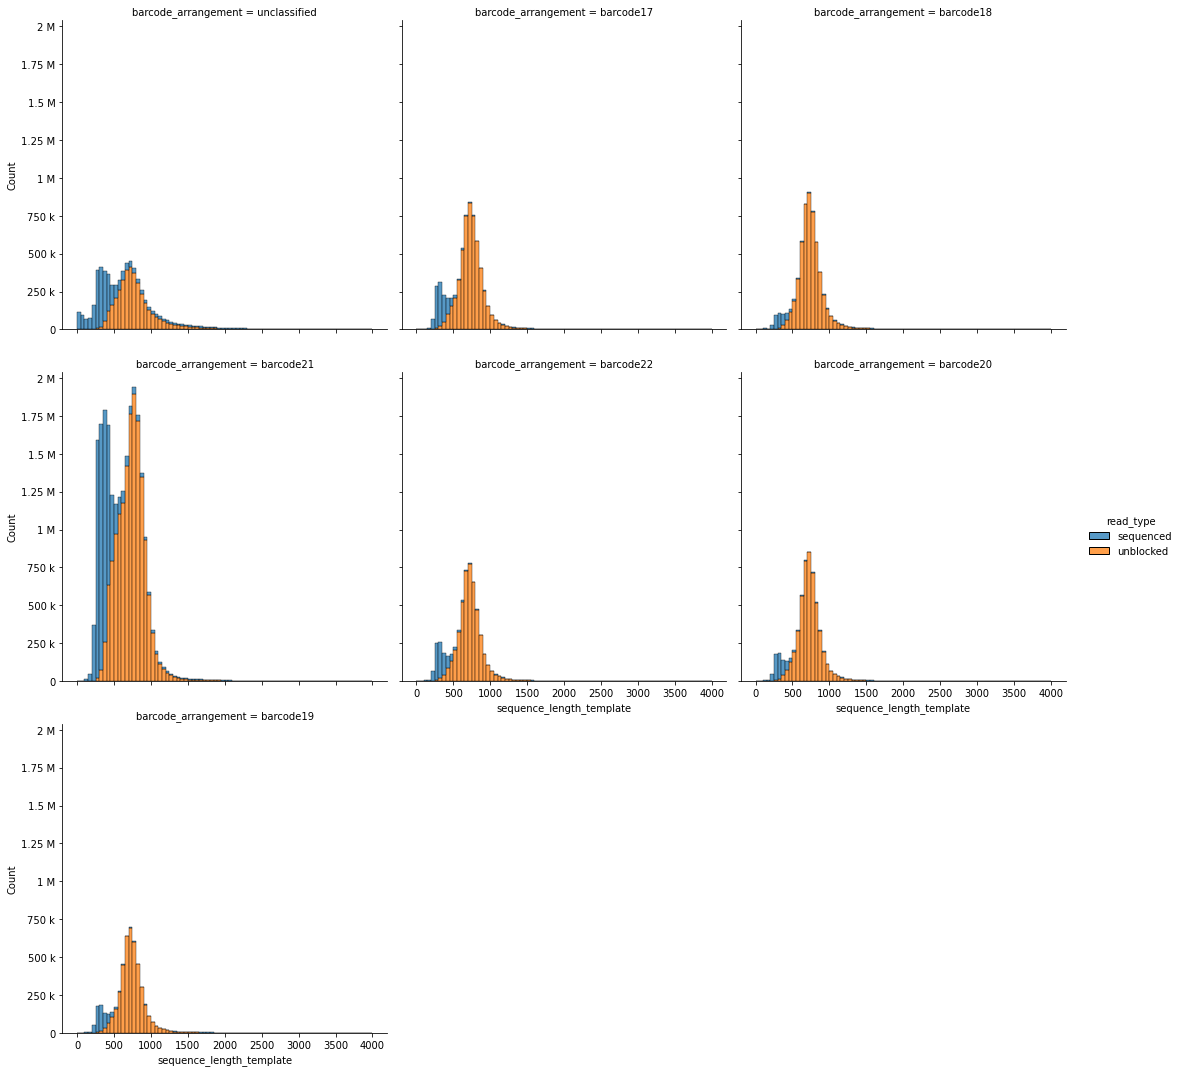

In [76]:
g = sns.displot(
    data=prom_df[prom_df["barcode_arrangement"].isin(set(barcodes))],
    x="sequence_length_template",
    col="barcode_arrangement",
    col_wrap=3,
    stat="count",
    binrange=(0, 4000),
    binwidth=50,
    hue="read_type",
    multiple="stack"
)
# Apply engineering formatter to Y axis
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(mticker.EngFormatter())
g.savefig("supplementary_figure_5.pdf")

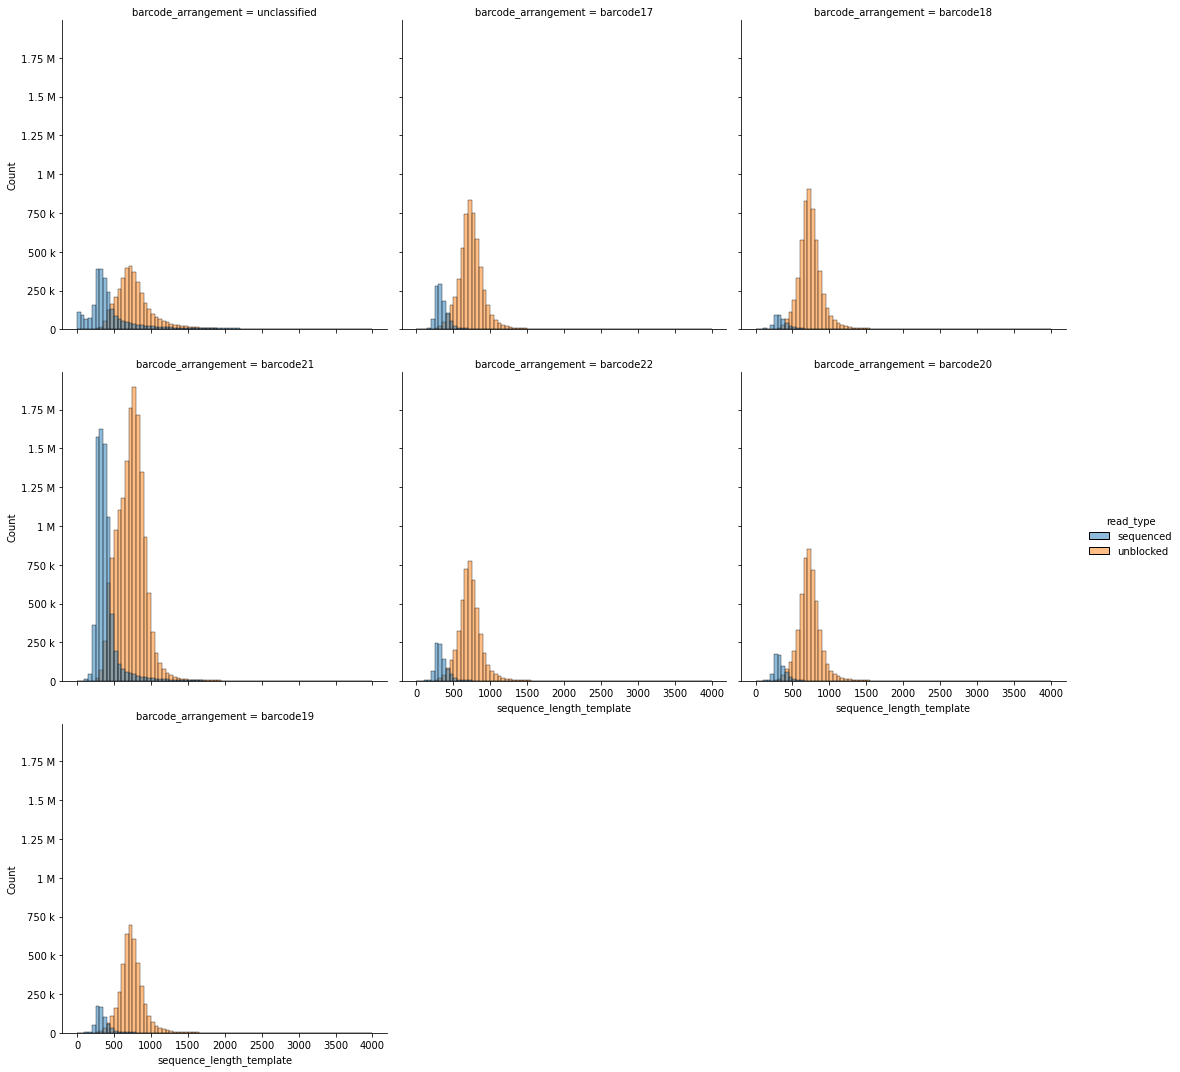

In [75]:
g = sns.displot(
    data=prom_df[prom_df["barcode_arrangement"].isin(set(barcodes))],
    x="sequence_length_template",
    col="barcode_arrangement",
    col_wrap=3,
    stat="count",
    binrange=(0, 4000),
    binwidth=50,
    hue="read_type",
    multiple="layer"
)
# Apply engineering formatter to Y axis
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(mticker.EngFormatter())


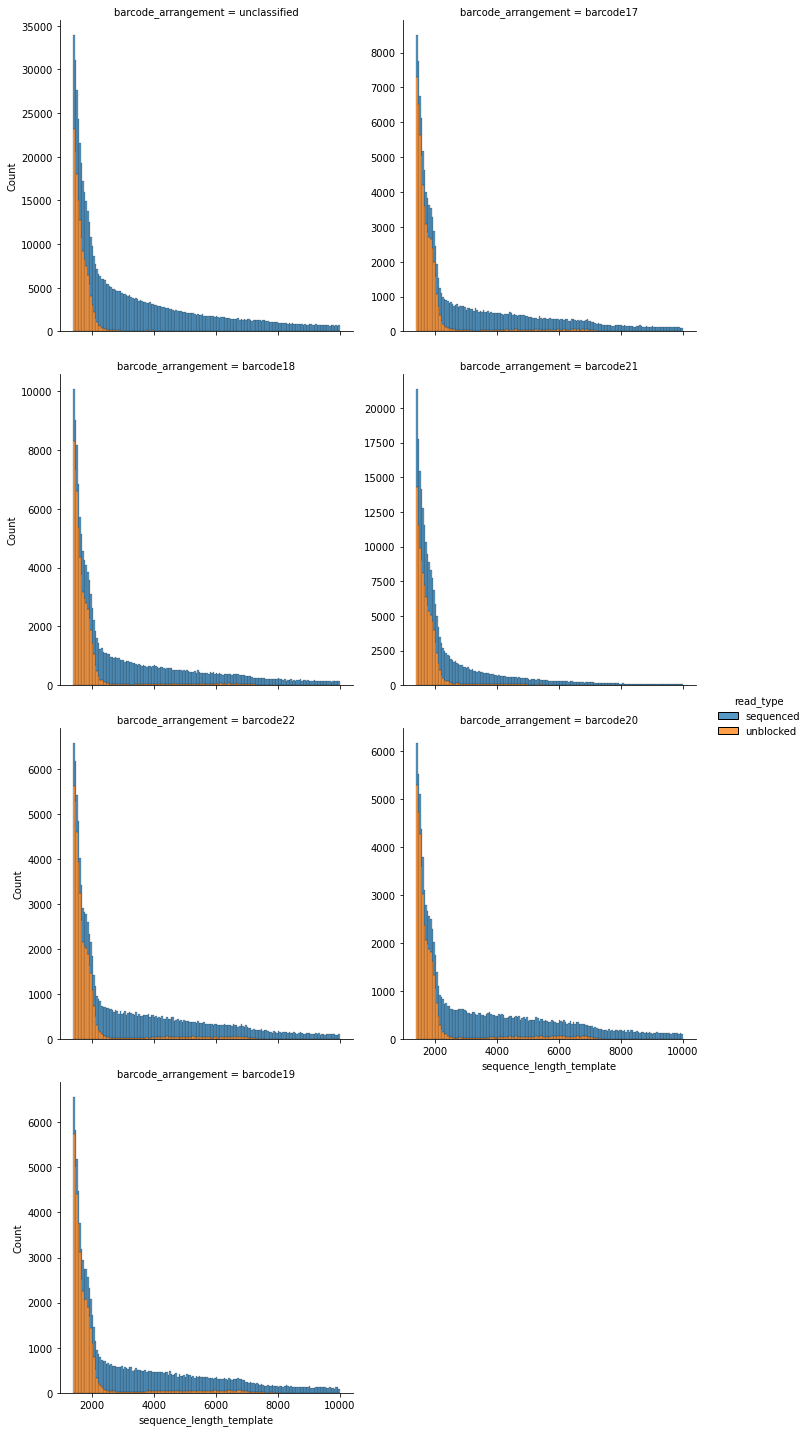

In [44]:
g = sns.displot(
    data=prom_df[prom_df["barcode_arrangement"].isin(set(barcodes))],
    x="sequence_length_template",
    col="barcode_arrangement",
    col_wrap=3,
    stat="count",
    binrange=(1400, 10000),
    binwidth=50,
    hue="read_type",
    multiple="stack",
    facet_kws={"sharey": False}
)

In [59]:
unc_df = prom_df[(prom_df["barcode_arrangement"]=="unclassified") & (prom_df["sequence_length_template"] >= 5000) & (prom_df["read_type"] == "sequenced")]

In [68]:
unc_df.iloc[int(261786/2):int(261786/2)+10]

,read_id,sample_id,sequence_length_template,barcode_arrangement,read_type
10159488,bd7a7681-2d0a-4686-9603-b2d976e36335,ds1332_4,6253,unclassified,sequenced
10159490,5767f91b-4d4c-46bd-8139-cbf4ab2bf717,ds1332_4,31807,unclassified,sequenced
10159492,357f3dc5-041a-46e1-b81e-d57b9f2cd65e,ds1332_4,55592,unclassified,sequenced
10159494,8be8e0f6-d5ed-4e71-bbc6-5f372a86281c,ds1332_4,19676,unclassified,sequenced
10159499,c1f9aa39-0c59-498f-bd0c-4a3a975db892,ds1332_4,31958,unclassified,sequenced
10159501,b6f3a585-fb77-48d8-9770-c3006b78f58d,ds1332_4,13253,unclassified,sequenced
10159502,e80ae4ea-fee1-4f1b-93d0-112896910666,ds1332_4,11734,unclassified,sequenced
10159503,47d694cc-aeff-41b7-b74e-f306232a723c,ds1332_4,54456,unclassified,sequenced
10159504,a8061254-a389-442f-89da-ea102e870511,ds1332_4,26928,unclassified,sequenced
10159505,3202a40a-8310-4bb6-b25e-a8f25957abd4,ds1332_4,20449,unclassified,sequenced


In [29]:
df = pd.read_csv("nanoplot_seq/NanoStats_barcoded.txt", sep="\t")

In [30]:
df

,Metrics,unclassified,barcode17,barcode18,barcode21,barcode22,barcode20,barcode19,barcode23,barcode06,...,barcode15,barcode05,barcode09,barcode13,barcode01,barcode08,barcode02,barcode03,barcode14,barcode07
0,number_of_reads,3133654,1171712,554657,7544908,985165,721995,720920,261,165,...,238,202,170,285,212,145,147,142,47,59
1,number_of_bases,6183032367.0,1272536278.0,1273928473.0,3401415199.0,1140346633.0,1030457034.0,1057502351.0,849119.0,497546.0,...,642353.0,780008.0,430241.0,568640.0,839319.0,265156.0,491190.0,406986.0,268465.0,117804.0
2,median_read_length,391.0,336.0,382.0,354.0,332.0,335.0,335.0,570.0,529.0,...,531.5,1100.5,593.0,552.0,901.0,434.0,584.0,457.5,628.0,556.0
3,mean_read_length,1973.1,1086.0,2296.8,450.8,1157.5,1427.2,1466.9,3253.3,3015.4,...,2699.0,3861.4,2530.8,1995.2,3959.1,1828.7,3341.4,2866.1,5712.0,1996.7
4,read_length_stdev,6583.5,4046.4,6451.9,892.7,4255.5,4711.2,5020.6,6857.5,7420.3,...,5803.1,6946.5,10434.3,5224.0,7417.8,4075.3,8941.5,6486.2,12650.3,5008.4
5,n50,12575.0,8599.0,14402.0,406.0,9398.0,10872.0,12606.0,13867.0,13887.0,...,8722.0,13452.0,10676.0,10486.0,15406.0,9401.0,18745.0,24469.0,40782.0,5681.0
6,active_channels,2525,2437,2439,2447,2436,2436,2437,234,159,...,216,187,156,256,195,140,138,135,44,59
7,mean_qual,6.2,11.6,10.0,12.1,11.4,11.2,11.0,5.3,5.9,...,5.1,5.0,5.2,5.6,5.1,5.5,5.4,5.6,5.7,5.7
8,median_qual,6.7,14.4,13.7,14.5,14.4,14.2,14.0,5.6,6.2,...,5.3,5.3,5.4,6.1,5.6,5.8,5.8,5.7,6.1,6.1
9,longest_read_(with_Q):1,805961 (3.2),937668 (3.6),282301 (6.9),162607 (3.5),315522 (4.2),187844 (14.7),237301 (6.3),42753 (2.5),58676 (6.8),...,41925 (4.7),47622 (5.9),129665 (5.2),43988 (4.5),45456 (6.1),36878 (7.7),63508 (4.4),34515 (5.5),60591 (6.7),33725 (4.8)
